**Fine Tuning of Existing Model for Classification**

**Download dataset from Kaggle**

In [1]:
! pip install -q kaggle             # kaggle installation in colab environment
from google.colab import files      # importing files for handaling directory in colab
import os, shutil, pathlib          # importing os for creating directory, unzipping, copying in colab


In [ ]:
#kaggle API uploading pop-up
files.upload()


In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
#downloading dogs-vs-cats data-set from kaggle

!kaggle competitions download -c dogs-vs-cats

 98% 797M/812M [00:04<00:00, 110MB/s] 
100% 812M/812M [00:04<00:00, 206MB/s]


In [8]:
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

**A subset of the original dataset is used for this homework**

In [9]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

**Classification**

In [10]:
#importing necessary libraries and API
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt

**Data Pre-processing**

make inputimage size 180 x 180 x 3

nd  batch size 32

In [11]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


**Data Augmentation**

In [12]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomZoom(0.2),
        layers.RandomRotation(0.1),
    ]
)

**Taking ResNet50 as the Base model**

ResNet50, initialized with ImageNet weights, follows a four-stage architecture built on a bottleneck residual design. Each residual unit comprises a sequence of three convolutional layers arranged as 1×1, 3×3, and 1×1 convolutions. In the final (fourth) stage, there are three such residual units, totaling nine layers. For fine-tuning, I freeze this last stage—specifically, the bottom 9 layers within it.

In [13]:
conv_base  = keras.applications.resnet50.ResNet50(
    weights="imagenet",
    include_top=False)

#Perform fine-tuning by retaining the entire original network architecture, but unfreezing only the last 9 layers for training
conv_base.trainable = True
for layer in conv_base.layers[:-9]:
    layer.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
inputs = keras.Input(shape=(180, 180, 3))                                  # inputs data
x = data_augmentation(inputs)                                              # call data-augmentation function
x = keras.applications.resnet50.preprocess_input(x)                        # pre-process the data for ResNHet50
x = conv_base(x)                                                           # ResNet50 as the base model
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [15]:
#compiling
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

#call back function for saving the best trained model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning_ResNet50.keras",
        save_best_only=True,
        monitor="val_loss")
        ]

In [16]:
# training the model
history = model.fit(
    train_dataset,
    epochs=25,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 269ms/step - accuracy: 0.7987 - loss: 0.8227 - val_accuracy: 0.9710 - val_loss: 0.1068
Epoch 2/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 210ms/step - accuracy: 0.9420 - loss: 0.2016 - val_accuracy: 0.9760 - val_loss: 0.0791
Epoch 3/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 170ms/step - accuracy: 0.9680 - loss: 0.1353 - val_accuracy: 0.9800 - val_loss: 0.0700
Epoch 4/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 148ms/step - accuracy: 0.9587 - loss: 0.1474 - val_accuracy: 0.9680 - val_loss: 0.1575
Epoch 5/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.9652 - loss: 0.1278 - val_accuracy: 0.9800 - val_loss: 0.0752
Epoch 6/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 187ms/step - accuracy: 0.9790 - loss: 0.0857 - val_accuracy: 0.9690 - val_loss: 0.1222
Epoch 7/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 188ms/step - accuracy: 0.9667 - loss: 0.1152 - val_accuracy: 0.9820 - val_loss: 0.0731
Epoch 8/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 189ms/step - accuracy: 0.9708 - loss: 0.0851 - val_accu

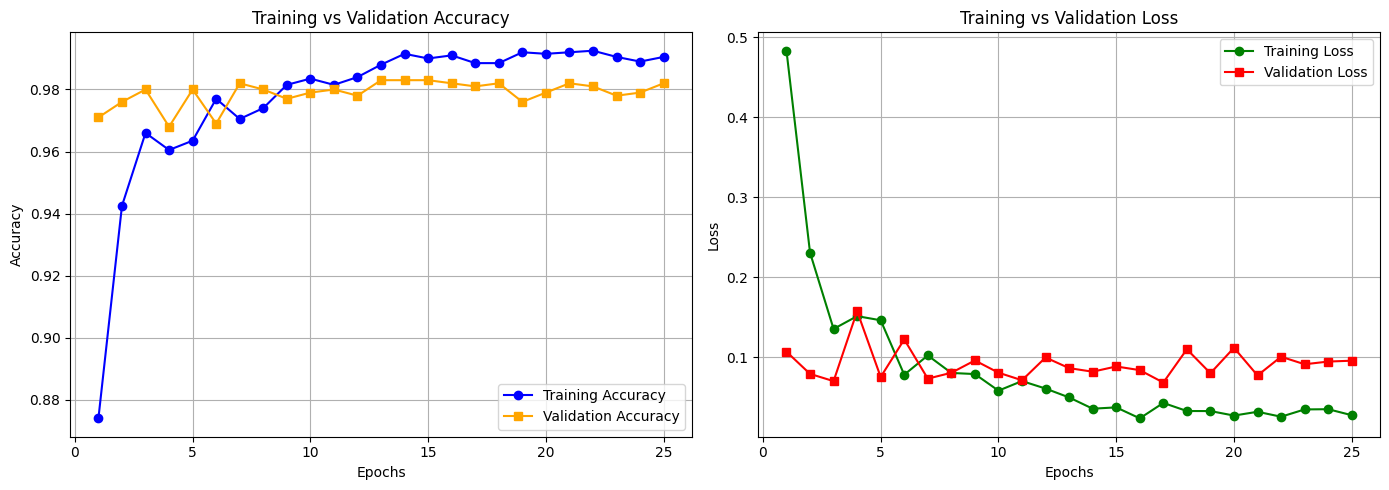

In [20]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

# Set up the figure with 1 row, 2 columns
plt.figure(figsize=(14, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, marker='o', color='blue', label='Training Accuracy')
plt.plot(epochs, val_acc, marker='s', color='orange', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, marker='o', color='green', label='Training Loss')
plt.plot(epochs, val_loss, marker='s', color='red', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [21]:
# testing the model
model = keras.models.load_model("fine_tuning_ResNet50.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.9817 - loss: 0.0924
Test loss: 0.0971
Test accuracy: 0.9815


**Test Results**

Test Accuracy: 98.15%

Test Loss: 9.71 %